# Load Data, Import stuff

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import json
import datetime
from json import JSONDecoder

% matplotlib inline


UsageError: Line magic function `%` not found.


In [ ]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.io as pio

init_notebook_mode()

In [2]:

import textstat
from nltk.corpus import stopwords

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import classification_report, f1_score
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from xgboost.sklearn import XGBRegressor
from statsmodels.discrete.discrete_model import Poisson, NegativeBinomial
from scipy.sparse import issparse

## Read raw data

In [14]:
train_file = "./sampleData/train_reviews_restaurants.csv"
test_file = "./sampleData/test_reviews_restaurants.csv"
reviews_train  = pd.read_csv(train_file)
reviews_test = pd.read_csv(test_file)

# User Features

In [4]:
def computeUserScore():
    score_dict = {}
    with open('../yelp_dataset/yelp_academic_dataset_user.json') as input_file:
            count=0
            for user in input_file:
                usr = json.loads(user)
                total_votes = usr['useful'] + usr['funny'] + usr['cool']
                if(usr['review_count'] == 0):
                    score =0
                else:
                    score = total_votes/ usr['review_count']
                score_dict[usr['user_id']] = round(score,3)
    input_file.close()
    return score_dict

In [5]:
def computeUserFeatures():
    user_dict = {}
    score_dict = computeUserScore()
    with open('../yelp_dataset/yelp_academic_dataset_user.json') as user_file:
        count=0
        for user in user_file:
            usr = json.loads(user)
            yelping_since = usr['yelping_since']
            fans = usr['fans']
            review_count = usr['review_count']
            avg_stars = usr['average_stars']
            if(usr['elite']=="None"):
                elite_count=0
            else:
                elite_count= len(usr['elite'].split(', '))
            usr['elite_count'] = elite_count

            total_votes = usr['useful'] + usr['funny'] + usr['cool']
            if(usr['review_count'] == 0):
                score = 0
            else:
                score = round(total_votes/ usr['review_count'], 3)
            usr['score'] = score
            total_score=0
            max_score = 0
            if(usr['friends']!= "None"):
                friends= usr['friends'].split(', ')
                friend_count = len(friends)
                for friend in friends:
                    if(friend in score_dict):
                        total_score = total_score + score_dict[friend]
                        max_score = max(max_score, score_dict[friend])
                avg_nw_score = round(total_score/friend_count, 3)
                max_nw_score = max_score
            else:
                friend_count = 0
                avg_nw_score = 0
                max_nw_score = 0
            features = [fans, avg_stars, review_count,  elite_count, total_votes, score, avg_nw_score, max_nw_score, friend_count, yelping_since]
            user_dict[usr['user_id']] = features
    return user_dict

In [6]:
def days_between(review_data, yelping_since):
    yelp_join_dt = datetime.datetime.strptime(yelping_since,'%Y-%m-%d')
    review_datetime = datetime.datetime.strptime(review_data,'%Y-%m-%d')
    return (review_datetime-yelp_join_dt).days

## Regression

In [7]:
def run_regression(reviews_df, create_model, create_vectorizer, num_train=None, num_test=None, weight_fn=None):
    train_df, test_df = train_test_split(reviews_df, test_size=0.2)
    if num_train:
        train_df = train_df.sample(num_train)
    if num_test:
        test_df = test_df.sample(num_test)
    model = create_model()
    vectorizer = create_vectorizer()
    vectorizer.fit(train_df)
    print('Fit vectorizer')
    train_vectors = vectorizer.transform(train_df)
    test_vectors = vectorizer.transform(test_df)
    print('Created vectors')
    train_vote_count = train_df['total_votes'].values
    if weight_fn:
        model.fit(train_vectors, train_vote_count, sample_weight=weight_fn(train_df))
    else:
        model.fit(train_vectors, train_vote_count)
    print('Fit model')
    plot_residuals(model, train_vectors, train_df['total_votes'].values)
    plot_residuals(model, test_vectors, test_df['total_votes'].values)

In [8]:
def plot_residuals(model, vectors, true_y):
    pred = model.predict(vectors)
    diff = true_y - pred
    print(f'R squared: {model.score(vectors, true_y):.4f}')
    plt.title('Residual Plot')
    plt.scatter(true_y, diff, marker='o')

In [9]:
class PandasCountVectorizer(TransformerMixin):
    # A bag-of-words vectorizer that works with an entire DataFrame as input.
    # This lets me create a combined feature pipeline with multiple feature vectorizers
    # where I don't have to worry about passing different columns to each.

    def __init__(self, *args, **kwargs):
        self.vectorizer = CountVectorizer(*args, **kwargs)

    def fit(self, X, *args, **kwargs):
        self.vectorizer.fit(X['text'].values)
        return self

    def transform(self, X):
        return self.vectorizer.transform(X['text'].values)

In [10]:
class CustomFeatures(TransformerMixin):
    # A feature vectorizer that creates features based on length, readability and review stars.
    # Use this to add other new custom features (like sentiment and user history maybe)
    # Btw, I think sentiment might not help much - intuitively it seems like it'd be highly correlated with 
    # review stars - 5 star rating - likely positive; 1 star rating - likely negative.

    def fit(self, *args, **kwargs):
        return self
    
    def _review_features(self, review):
        return [
            len(review.text),
            review.stars,
            review.coleman_liau_index,
            review.automated_readability_index,
            review.dale_chall_readability_score,
            review.linsear_write_formula,
            review.gunning_fog,
            review.flesch_reading_ease,
            review.fans,
            review.usr_avg_stars,
            review.usr_review_count,
            review.elite_count,
            review.usr_total_votes,
            review.usr_score,
            review.avg_nw_score,
            review.max_nw_score,
            review.friend_count,
            review.posted_days
        ]

    def transform(self, reviews):
        return np.array([self._review_features(r) for r in reviews.itertuples()])

In [15]:
# Ordinary Linear Regression with bag of words with basic filtering
bow_vectorizer_fn = lambda: PandasCountVectorizer(min_df=10, max_df=0.75, max_features=1000)

In [16]:
### User features are claculated and written to file, hence needn't be recalculated ###

#user_features = computeUserFeatures()
#user_pd = pd.DataFrame.from_dict(user_features, orient='index',  columns=['fans', 'usr_avg_stars', 'usr_review_count', 'elite_count', 'usr_total_votes', 'usr_score', 'avg_nw_score', 'max_nw_score', 'friend_count', 'yelping_since'])
#reviews_train = reviews_train_data.join(user_pd, on="user_id")
#reviews_train['posted_days'] = reviews_train.apply(lambda x : days_between(x['date'], x['yelping_since']), axis=1)


Fit vectorizer
Created vectors
Fit model
R squared: 0.1982
R squared: 0.0499


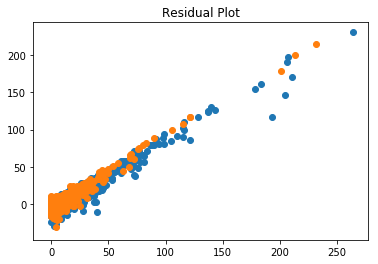

In [17]:
run_regression(reviews_train, LinearRegression, bow_vectorizer_fn)

The plot above shows residuals on the y-axis (true vote count - predicted vote count) vs the true vote count on the x-axis. Residual plots are a commonly used tool to understand the results of regression analysis and their validity. Here, we see that the residual grows almost linearly (with a coefficient of ~1) with the true value. This is a major problem - it means that the model predicts 0 for most reviews with non-zero vote counts.

This may be happening because of the uneven distribution of examples we have - most examples have very few votes, so the cost function of the regression model (mean squared error) is minimized by simply predicting zero/close to zero for most examples.

The second thing to look at the is the R-squared value - the first is on the train set, the second on a validation set. The fact that it is significantly lower for the validation set indicates a significant degree of overfitting.

### Add readability scores

In [70]:
# Code to compute readability scores, add them to the pandas df, and save to file
# Commenting it out since there's no need to run this again. Leaving it for reference
# in case it needs to be run on other data

#readability_fns = [
#    textstat.coleman_liau_index,
#    textstat.automated_readability_index,
#    textstat.dale_chall_readability_score,
#    textstat.linsear_write_formula,
#    textstat.gunning_fog,
#    textstat.flesch_reading_ease,
#    ]
#for fn in readability_fns:
#    print(fn.__name__)
#    reviews_train[fn.__name__] = reviews_train['text'].apply(fn)
#reviews_train.to_csv(train_file)

coleman_liau_index
automated_readability_index
dale_chall_readability_score
linsear_write_formula
gunning_fog
flesch_reading_ease


In [18]:
# Linear Regression with bag-of-words + custom features (length, review stars, different readability scores)
bow_readability_vectorizer_fn = lambda: FeatureUnion([
    ('bow', PandasCountVectorizer(min_df=10, max_df=0.75, max_features=1000)),
    ('custom', CustomFeatures()),
])

Fit vectorizer
Created vectors
Fit model
R squared: 0.4805
R squared: 0.3040


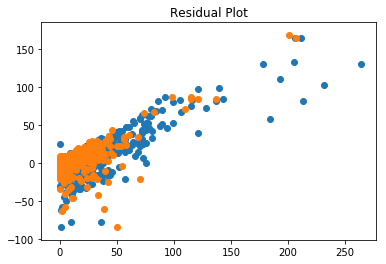

In [19]:
run_regression(reviews_train, LinearRegression, bow_readability_vectorizer_fn)

Slightly better, but hardly. If our regression model is to be any good, our residuals need to be normally distributed with a zero mean AND we need a decent R-squared value for both train/validation sets (greater than 0.3-0.4 at least). Something like this for the residual plot - 

In [20]:
# Image off the internet, not something i've achieved on our data
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "./residuals.png")

### Regression with weights

Next I tried weighted regression - since we have lots of data with near-zero votes and very few with high votes, I decided to add a weight to each training example proportional to its vote count. I experimented with different formulae - nothing helps much.

In [21]:
weight_by_votes = lambda df: 1 + df.total_votes.values/10

Fit vectorizer
Created vectors
Fit model
R squared: -0.0968
R squared: -0.5580


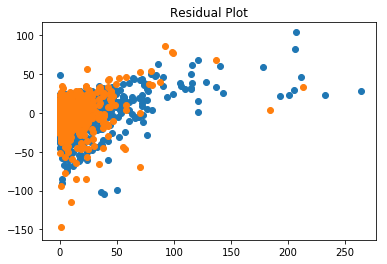

In [22]:
run_regression(reviews_train, LinearRegression, bow_readability_vectorizer_fn, weight_fn=weight_by_votes)

We still have a linear-ish residual plot. And, the R-squared values are absolutely horrible.

### Other regression models

The problem may not be suited to linear regression at all - so I tried XGB and Random Forest based regression. I couldn't find simple python libraries for the regression models Nikhikta/Prof suggested - Tobit, Poisson and Negative Binomial regression.

In [24]:
# XGBoost, bag-of-words + custom features
create_xgboost_regressor = lambda: XGBRegressor(objective='count:poisson')

Fit vectorizer
Created vectors
Fit model
R squared: -3265.4754
R squared: -7451.0442


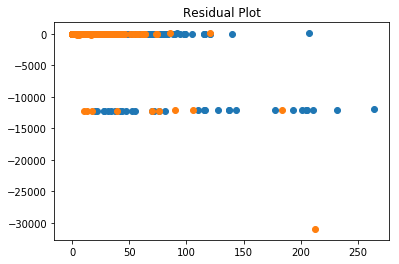

In [25]:
run_regression(reviews_train, create_xgboost_regressor, bow_readability_vectorizer_fn)

Fit vectorizer
Created vectors
Fit model
R squared: -101375978362777264908050785894400.0000
R squared: -139240061841272051164863822561280.0000


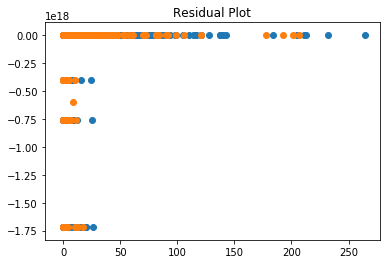

In [27]:
# weighted XGBoost, bag-of-words + custom features
# Results in weird errors sometimes - it looks like the model predicts NaN values sometimes
run_regression(reviews_train, create_xgboost_regressor, bow_readability_vectorizer_fn, weight_fn=weight_by_votes)

Fit vectorizer
Created vectors


/Users/asra/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fit model
R squared: 0.8974
R squared: 0.5003


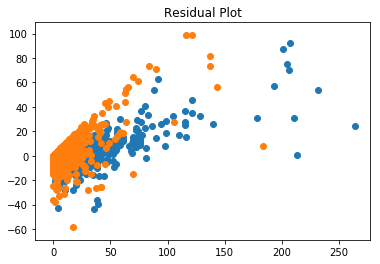

In [28]:
# Random Forest regression, bag-of-words + custom features
run_regression(reviews_train, RandomForestRegressor, bow_readability_vectorizer_fn)

Fit vectorizer
Created vectors


/Users/asra/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Fit model
R squared: 0.9060
R squared: 0.3831


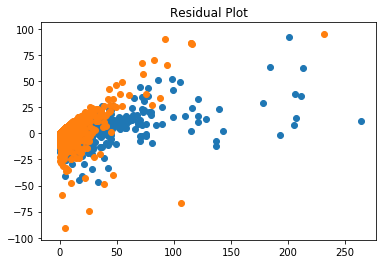

In [29]:
# weighted Random Forest regression, bag-of-words + custom features
run_regression(reviews_train, RandomForestRegressor, bow_readability_vectorizer_fn, weight_fn=weight_by_votes)

In [30]:
class StatsmodelRegressor(RegressorMixin):
    def __init__(self, *args, **kwargs):
        if args or kwargs:
            print(f'WARNING: Ignoring {args}, {kwargs}')
        self.model = None
        self.params = None
    
    def _init_model(self, X, y):
        raise NotImplementedError

    def fit(self, X, y, *args, **kwargs):
        if args or kwargs:
            print(f'WARNING: Ignoring {args}, {kwargs}')
        if issparse(X):
            X = X.todense()
        self.model = self._init_model(X, y)
        self.params = self.model.fit(maxiter=100)
        return self
    
    def predict(self, X):
        if not self.model:
            raise ValueError('Model needs to be fit first')
        if issparse(X):
            X = X.todense()
        return self.model.predict(self.params.params, exog=X)


class NegativeBinomialRegressor(StatsmodelRegressor):
    
    def _init_model(self, X, y):
        return NegativeBinomial(y, X)


class PoissonRegressor(StatsmodelRegressor):
    
    def _init_model(self, X, y):
        return Poisson(y, X)

In [ ]:
# Poisson regression, bag-of-words + custom features
run_regression(reviews_train, PoissonRegressor, bow_readability_vectorizer_fn, num_train=2000, num_test=5000)

In [ ]:
# Negative Binomial regression, bag-of-words + custom features
run_regression(reviews_train, NegativeBinomialRegressor, bow_readability_vectorizer_fn, num_train=2000, num_test=5000)

Both the above models didn't converge/crashed with bag-of-words features - possibly because of high dimensionality.
So I decided to implement topic models next to reduce the feature dimensionality.

## Adding topics as features

One challenge here is that training topic models is sloww. Thankfully, we don't necessarily need to train them on the entire 50k/40k/32k dataset. Training them on a few thousand reviews works well enough.

Also, it's not THAT bad - we could train it on the entire 50k dataset in a few hours - maybe for the final run, we should do that.

In [32]:
from gensim.models.wrappers.ldamallet import LdaMallet
from gensim.models import LdaModel, LsiModel
from gensim.corpora import Dictionary
mallet_path = '../mallet-2.0.8/bin/mallet'

import re

class Corpus():
    def __init__(self, texts):
        dictionary = Dictionary([self.text_to_tokens(text) for text in texts])
        dictionary.filter_extremes(no_below=5, no_above=0.6)
        self._dictionary = dictionary
        self._texts = texts

    def text_to_tokens(self, text):
        return [w for w in re.split('\W', text) if w]
    
    def doc2bow(self, text):
        return self._dictionary.doc2bow(self.text_to_tokens(text))

    def __iter__(self):
        for text in self._texts:
            yield self.doc2bow(text)


class TopicModelVectorizer(TransformerMixin):
    def __init__(self, model, corpus):
        self._model = model
        self._corpus = corpus

    def fit(self, *args, **kwargs):
        return self
    
    def transform(self, reviews):
        all_reviews_topic_scores = self._model[
            [self._corpus.doc2bow(review) for review in reviews.text.values]
        ]
        return np.array(
            [
                [tup[1] for tup in review_topic_scores]
                for review_topic_scores in all_reviews_topic_scores
            ])

In [33]:
# To train new topic models
# basically pass corpus a list of review texts, and then pass the corpus stuff to LdaMallet
# you can also use the topic model i've already trained on some restaurant data below

load_existing = True  # Set to False if you want to train a new one
model_path = './models/restaurant_topics_100'

def load_topic_model(model_path):
    with open(model_path, 'rb') as f:
        loaded = pickle.load(f)
    return loaded['corpus'], loaded['topic_model']

def save_model(model_path, corpus, topic_model):
    with open(model_path, 'wb') as f:
        pickle.dump({'corpus': corpus, 'topic_model': topic_model}, f)

if load_existing:
    corpus, topic_model = load_topic_model(model_path)
else:
    save_path = None  # Specify this if training a new model to save to that file
    corpus = Corpus(reviews_train.text.values[:1000])
    topic_model = LdaMallet(mallet_path, corpus=corpus, id2word=corpus._dictionary)
    save_model(save_path, corpus, topic_model)

In [34]:
#topic_model.print_topics(100)

In [35]:
topic_and_readability_vectorizer_fn = lambda: FeatureUnion([
    ('bow', TopicModelVectorizer(topic_model, corpus)),
    ('custom', CustomFeatures()),
])

In [ ]:
# Linear regression, topics + custom features (length, stars, readability)
run_regression(reviews_train, LinearRegression, topic_and_readability_vectorizer_fn, num_train=5000, num_test=1000)

In [ ]:
# Random forest regression, topics + custom features (length, stars, readability)
run_regression(reviews_train, RandomForestRegressor, topic_and_readability_vectorizer_fn, num_train=5000, num_test=1000)

Fit vectorizer
Created vectors
Fit model
R squared: 0.6155
R squared: 0.0375


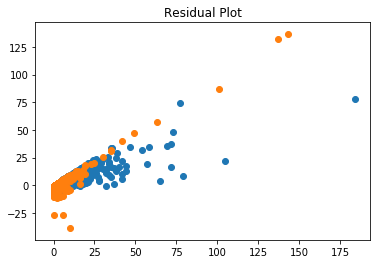

In [70]:
# XGB regression, topics + custom features (length, stars, readability)
run_regression(reviews_train, XGBRegressor, topic_and_readability_vectorizer_fn, num_train=5000, num_test=1000)

Fit vectorizer
Created vectors
Optimization terminated successfully.
         Current function value: 2.942423
         Iterations 20
Fit model
R squared: 0.2637
R squared: -0.7480


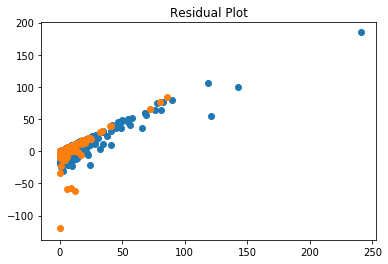

In [75]:
# Poisson regression, topics + custom features (length, stars, readability)
run_regression(reviews_train, PoissonRegressor, topic_and_readability_vectorizer_fn, num_train=5000, num_test=1000)

Fit vectorizer
Created vectors


/home/jayant/miniconda3/envs/py_ml_hw1/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:2468: RuntimeWarning:

divide by zero encountered in log

/home/jayant/miniconda3/envs/py_ml_hw1/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:2560: RuntimeWarning:

overflow encountered in multiply

/home/jayant/miniconda3/envs/py_ml_hw1/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:2560: RuntimeWarning:

invalid value encountered in true_divide

/home/jayant/miniconda3/envs/py_ml_hw1/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:2563: RuntimeWarning:

invalid value encountered in true_divide

/home/jayant/miniconda3/envs/py_ml_hw1/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:2468: RuntimeWarning:

divide by zero encountered in log



         Current function value: 1.711540
         Iterations: 100
         Function evaluations: 124
         Gradient evaluations: 114


/home/jayant/miniconda3/envs/py_ml_hw1/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit model
R squared: -2.2808
R squared: -0.4374


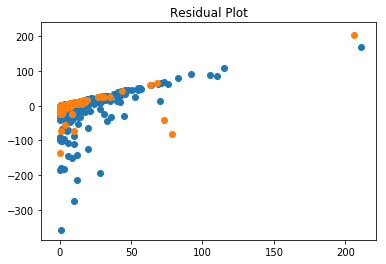

In [76]:
# Negative Binomial regression, topics + custom features (length, stars, readability)
run_regression(reviews_train, NegativeBinomialRegressor, topic_and_readability_vectorizer_fn, num_train=5000, num_test=1000)

End results - pretty meh. Out of ideas at this point. User features, maybe. And maybe following what Koustuv suggested on Piazza.

## Next Steps

Not entirely sure - doesn't look like regression is working well.

I'd recommend we switch to classification right away if user features don't work well, run our experiments quickly, figure out feature importances and come up with results that we can explain and present.

Maybe we could split the tasks into the following (can be done in parallel: for example, we don't need to wait to see if user features help with regression, we can get started with classification right away) - 
- Include user and network features into regression model and see if it improves things
- Implement the classification model pipeline, including feature importance
- Look into SAGE for comparing features across business categories
- Write code for creating data for different businesses and running the classification pipeline on each dataset
- Try out what Koustuv suggested and see if it helps